This notebook is for the paper: Cohen, Joseph Paul, et al. Predicting COVID-19 Pneumonia Severity on Chest X-Ray with Deep Learning. May 2020, http://arxiv.org/abs/2005.11856

The images are found here: https://github.com/ieee8023/covid-chestxray-dataset

The dataloader and models are found here: https://github.com/mlmed/torchxrayvision

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
sys.path.insert(0,"..")
sys.path.insert(0,"../..")
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import sys
import torch.nn.functional as F
import pandas as pd

In [3]:
import torchxrayvision as xrv

In [4]:
nn_model = xrv.models.DenseNet(weights="all")#.cuda()
nn_model.op_threshs = None # to prevent sigmoid

In [5]:
import torchvision, torchvision.transforms
transform = torchvision.transforms.Compose([xrv.datasets.XRayCenterCrop(),xrv.datasets.XRayResizer(224)])

In [6]:
dmerge = xrv.datasets.COVID19_Dataset(imgpath="../../../covid-chestxray-dataset/images",
                                      csvpath="../../../covid-chestxray-dataset/metadata.csv",
                                      transform=transform, views=["PA"])

In [7]:
dmerge

{'ARDS': {0.0: 184, 1.0: 15},
 'Bacterial Pneumonia': {0.0: 182, 1.0: 17},
 'COVID-19': {0.0: 46, 1.0: 153},
 'Chlamydophila': {0.0: 198, 1.0: 1},
 'Fungal Pneumonia': {0.0: 187, 1.0: 12},
 'Klebsiella': {0.0: 198, 1.0: 1},
 'Legionella': {0.0: 197, 1.0: 2},
 'MERS': {0.0: 199},
 'No Finding': {0.0: 194, 1.0: 5},
 'Pneumocystis': {0.0: 187, 1.0: 12},
 'Pneumonia': {0.0: 5, 1.0: 194},
 'SARS': {0.0: 191, 1.0: 8},
 'Streptococcus': {0.0: 186, 1.0: 13},
 'Viral Pneumonia': {0.0: 38, 1.0: 161}}


COVID19_Dataset num_samples=199 views=['PA']

In [8]:
scores = pd.read_csv("covid-severity-scores.csv", skiprows=5)
scores = scores.set_index("filename")

In [9]:
scores

,geographic_mean,opacity_mean
filename,,
01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg,6.0,4.0
03BF7561-A9BA-4C3C-B8A0-D3E585F73F3C.jpeg,2.7,2.0
1-s2.0-S0140673620303706-fx1_lrg.jpg,2.0,2.0
1-s2.0-S1684118220300608-main.pdf-001.jpg,3.7,3.0
1-s2.0-S1684118220300608-main.pdf-002.jpg,1.7,1.7
...,...,...
ryct.2020200028.fig1a.jpeg,2.0,1.7
ryct.2020200034.fig2.jpeg,1.3,1.3
ryct.2020200034.fig5-day0.jpeg,3.7,3.3


In [10]:
dmerge.csv = dmerge.csv.set_index("filename").join(scores, on="filename").reset_index()

In [11]:
dmerge.csv.geographic_mean[~dmerge.csv.geographic_mean.isna()].describe()

count    94.000000
mean      3.336170
std       2.369785
min       0.000000
25%       1.300000
50%       3.000000
75%       4.925000
max       8.000000
Name: geographic_mean, dtype: float64

In [12]:
dl = torch.utils.data.DataLoader(dmerge, batch_size=32, num_workers=64, pin_memory=True)

In [13]:
d_feats = []
d_preds = []
with torch.no_grad():
    for i, batch in enumerate(dl):
        imgs = batch["img"]#.cuda()
        out = nn_model.features(imgs)
        out = F.relu(out, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        pred = nn_model(imgs)
        d_feats.append(out.detach().cpu().numpy())
        d_preds.append(pred.detach().cpu().numpy())
        if i %10 == 0:
            print(i)
d_feats = np.concatenate(d_feats).reshape(-1,1024)
d_preds = np.concatenate(d_preds)

0


In [14]:
dmerge.csv = dmerge.csv.join(pd.DataFrame(d_preds, columns=xrv.datasets.default_pathologies))

In [15]:
d_preds.shape

(199, 18)

In [16]:
d_feats.shape

(199, 1024)

In [17]:
labels = dmerge.csv.geographic_mean
data = d_preds
data = data[:,[xrv.datasets.default_pathologies.index("Lung Opacity"),
               xrv.datasets.default_pathologies.index("Pneumonia"),
               xrv.datasets.default_pathologies.index("Infiltration"),
               xrv.datasets.default_pathologies.index("Consolidation")]]

In [18]:
import sklearn, sklearn.manifold
X_embedded = sklearn.manifold.TSNE(n_components=2, random_state=54).fit_transform(data)
X_embedded.shape

(199, 2)

In [19]:
# import warnings
# with warnings.catch_warnings():
#     warnings.simplefilter("ignore")
#     import umap
#     reducer = umap.UMAP()
#     X_embedded = reducer.fit_transform(data)
#     X_embedded.shape

In [20]:
X_embedded.shape[0]

199

In [21]:
#dmerge.csv.geographic_mean

In [22]:
targets = dmerge.csv.geographic_mean.astype(np.float)

In [23]:
#targets = dmerge.csv["Lung Opacity"]

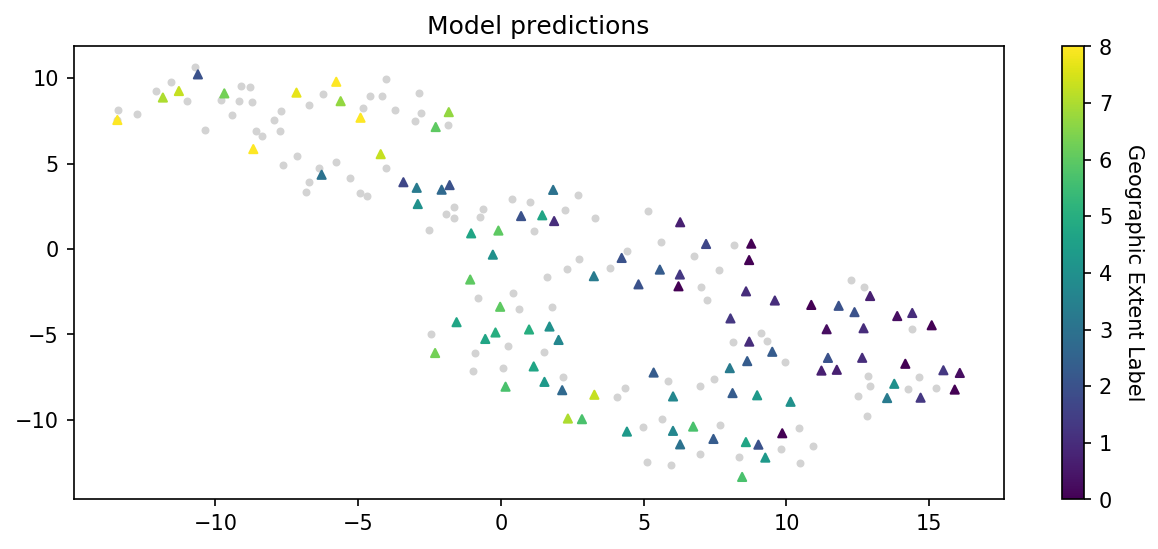

In [24]:
plt.figure(0, figsize=(10, 4), dpi=150)

plt.scatter(X_embedded[:,0][targets.isna()], 
            X_embedded[:,1][targets.isna()], 
            s=8,
            label="nan",
            c="lightgray"
            );

plt.scatter(X_embedded[:,0], 
            X_embedded[:,1], 
            #s=(targets==2)*20+1,
            c=targets,
            s=15,
            marker='^'
            );
#plt.clim(0,1)
cbar = plt.colorbar();
cbar.set_label('Geographic Extent Label', rotation=270, labelpad=15)
plt.title("Model predictions");



In [25]:
subset = dmerge.csv.iloc[np.where(~np.isnan(dmerge.csv.geographic_mean.astype(float)))]

In [26]:
subset.age[subset.sex == "M"].mean()


55.25

In [27]:
subset.age.std()


15.18177722670491

In [28]:
import sklearn, sklearn.linear_model, sklearn.metrics, sklearn.model_selection
import scipy, scipy.stats
def evaluate(data, labels, title, plot=True, groups=None, seed=0, method="mse", target_str=""):
    X = data
    y = labels.astype(float)
    
    gss = sklearn.model_selection.GroupShuffleSplit(train_size=0.5,test_size=0.5, random_state=seed)
    train_inds, test_inds = next(gss.split(X, y, groups))
    X_train, X_test, y_train, y_test = X[train_inds], X[test_inds], y.iloc[train_inds], y.iloc[test_inds]
    #print("X_train", X_train.shape, "X_test", X_test.shape)

    if method=="mse":
        model = sklearn.linear_model.LinearRegression()
    elif method=="huber":
        model = sklearn.linear_model.HuberRegressor()
    elif method=="mae":
        # loss = max(0, |y - p| - epsilon)
        model = sklearn.linear_model.SGDRegressor(loss="epsilon_insensitive", epsilon=0, l1_ratio=1, random_state=seed)
    
    model = model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    pdiff = y_test - y_pred
    
    res = {}
    res["name"] = title
    res["R^2"] = sklearn.metrics.r2_score(y_test, y_pred)
    res["Correlation"] = scipy.stats.pearsonr(y_pred,y_test)[0]
    res["< 0.7 ACC"] = ((y_pred - y_test) < 0.7).sum()/len(y_test)
    res["explained_variance"] = sklearn.metrics.explained_variance_score(y_test, y_pred)
    res["MAE"] = sklearn.metrics.mean_absolute_error(y_test, y_pred)
    res["MSE"] = sklearn.metrics.mean_squared_error(y_test, y_pred)
    res["method"] = method
    res["# params"] = "{}+1".format(model.coef_.shape[0])

    
    if plot:
        fig, ax = plt.subplots(figsize=(6,4), dpi=100)
        for x,y,yp in zip(y_test,y_test,y_pred):
            plt.plot((x,x),(y,yp),color='red',marker='')

        pmax = int(np.max([y_pred.max(), y_test.max()]))+2
        plt.plot(range(pmax),range(pmax), c="gray", linestyle="--")
        plt.xlim(0,pmax-1)
        plt.ylim(0,pmax-1)

        plt.scatter(y_test, y_pred);
        plt.ylabel("Model prediction ($y_{pred}$)")
        plt.xlabel("Ground Truth ($y_{true}$)")
        plt.title(title);
        plt.text(0.01,0.97, "$R^2$={0:0.2f}".format(res["R^2"])+ "\n"+ 
                 "Correlation={0:0.2f}".format(res["Correlation"]), ha='left', va='top', transform=ax.transAxes)

    return res#, pdiff


In [29]:
groups = dmerge.csv.patientid[~np.isnan(dmerge.csv.geographic_mean.astype(float))]

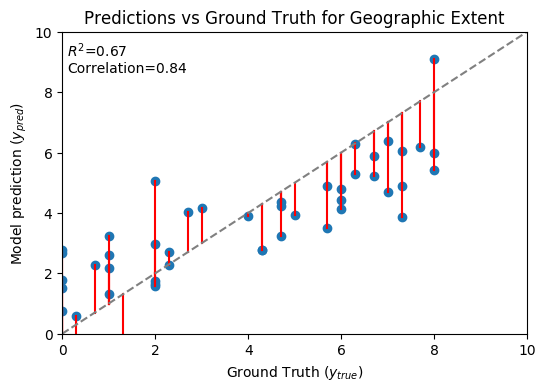

In [30]:
labels = dmerge.csv.geographic_mean[~np.isnan(dmerge.csv.geographic_mean.astype(float))]
data = d_preds[~np.isnan(dmerge.csv.geographic_mean.astype(float))]
data = data[:,[xrv.datasets.default_pathologies.index("Lung Opacity")]]
a = evaluate(data, labels,"Predictions vs Ground Truth for Geographic Extent", groups=groups, seed=1)


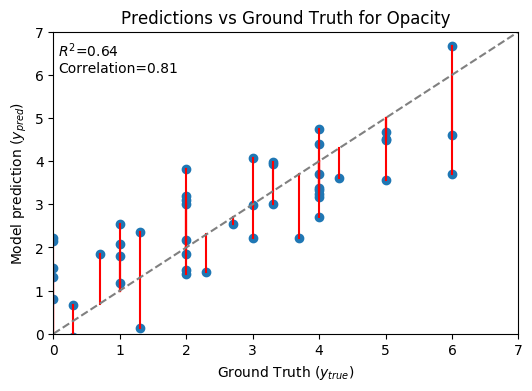

In [31]:
labels = dmerge.csv.opacity_mean[~np.isnan(dmerge.csv.opacity_mean.astype(float))]
data = d_preds[~np.isnan(dmerge.csv.geographic_mean.astype(float))]
data = data[:,[xrv.datasets.default_pathologies.index("Lung Opacity")]]
#data = np.concatenate([data,data**2], axis=1)
#data = data[:,[xrv.datasets.default_pathologies.index("Lung Opacity")]]
a = evaluate(data, labels,"Predictions vs Ground Truth for Opacity", groups=groups, seed=1)

In [32]:
results = pd.DataFrame()

In [33]:
target_str = "Geographic Extent"
labels = dmerge.csv.geographic_mean[~np.isnan(dmerge.csv.geographic_mean.astype(float))]

In [34]:
# target_str = "Opacity"
# labels = dmerge.csv.opacity_mean[~np.isnan(dmerge.csv.geographic_mean.astype(float))]

In [35]:
trials = 50
method = "mse"

In [36]:
data = d_feats[~np.isnan(dmerge.csv.geographic_mean.astype(float))]
for seed in range(trials):
    results = results.append(evaluate(data, labels, "Intermediate network features", plot=False, groups=groups,seed=seed, target_str=target_str, method=method), ignore_index=True)

In [37]:
data = np.zeros((data.shape[0],1))
for seed in range(trials):
    results = results.append(evaluate(data, labels, "No data", plot=False, groups=groups,seed=seed, target_str=target_str, method=method), ignore_index=True)


In [38]:
data = d_preds[~np.isnan(dmerge.csv.geographic_mean.astype(float))]
for seed in range(trials):
    results = results.append(evaluate(data, labels, "18 outputs", plot=False, groups=groups,seed=seed, target_str=target_str, method=method), ignore_index=True)
    

In [39]:
data = d_preds[~np.isnan(dmerge.csv.geographic_mean.astype(float))]
data = data[:,[xrv.datasets.default_pathologies.index("Lung Opacity"),
               xrv.datasets.default_pathologies.index("Pneumonia"),
               xrv.datasets.default_pathologies.index("Infiltration"),
               xrv.datasets.default_pathologies.index("Consolidation")]]
for seed in range(trials):
    results = results.append(evaluate(data, labels, "4 outputs", plot=False, groups=groups,seed=seed, target_str=target_str, method=method), ignore_index=True)
    

In [40]:
data = d_preds[~np.isnan(dmerge.csv.geographic_mean.astype(float))]
data = data[:,[xrv.datasets.default_pathologies.index("Lung Opacity")]]
for seed in range(trials):
    results = results.append(evaluate(data, labels, "lung opacity output", plot=False,groups=groups,seed=seed, target_str=target_str, method=method), ignore_index=True)
    

In [41]:
# data2 = d_feats[~np.isnan(dmerge.csv.geographic_mean.astype(float))]

# weights = model.classifier.weight[xrv.datasets.default_pathologies.index("Lung Opacity"),:].detach().cpu().numpy()
# data = data2[:,np.argsort(np.abs(weights))[-300:]]
# for seed in range(trials):
#     results = results.append(evaluate(data, labels, "Top 300 Features from Lung Opacity", seed=seed), ignore_index=True)

In [42]:
results.groupby(["name", "method"]).agg({
                             'Correlation':['mean','std'],
                             'R^2':['mean','std'],
                             'explained_variance':['mean','std'],
                             'MAE':['mean','std'],
                             'MSE':['mean','std']}).round(2)#.sort_values(("mean_squared_error", "mean"))


Correlation         R^2        \
                                            mean   std  mean   std   
name                          method                                 
18 outputs                    mse           0.77  0.06  0.50  0.19   
4 outputs                     mse           0.81  0.04  0.61  0.07   
Intermediate network features mse           0.74  0.08  0.47  0.15   
No data                       mse           0.00  0.00 -0.09  0.09   
lung opacity output           mse           0.81  0.04  0.60  0.08   

                                     explained_variance         MAE        \
                                                   mean   std  mean   std   
name                          method                                        
18 outputs                    mse                  0.53  0.18  1.31  0.20   
4 outputs                     mse                  0.64  0.07  1.17  0.12   
Intermediate network features mse                  0.50  0.15  1.34  0.13   
No data                       mse                 -0.00  0.00  2.07  0.17   
lung opacity output           mse                  0.63  0.07  1.16  0.10   

                                       MSE        
                                      mean   std  
name                          method              
18 outputs                    mse     2.73  0.93  
4 outputs                     mse     2.13  0.36  
Intermediate network features mse     2.86  0.61  
No data                       mse     5.97  0.90  
lung opacity output           mse     2.14  0.33

In [43]:
a = results.groupby(["name", "# params"]).agg({
                             'Correlation':['mean','std'],
                             'R^2':['mean','std'],
                             #'explained_variance':['mean','std'],
                             'MAE':['mean','std'],
                             'MSE':['mean','std']}).round(2).sort_values(("MAE", "mean"))

for c in a.columns.get_level_values(0).unique():
    a[c+"_"] =  a[(c, "mean")].apply("{0:0.2f}".format) + "±" + a[(c, "std")].apply("{0:0.2f}".format)
    del a[c]


In [44]:
a

,,Correlation_,R^2_,MAE_,MSE_
,,,,,
name,# params,,,,
lung opacity output,1+1,0.81±0.04,0.60±0.08,1.16±0.10,2.14±0.33
4 outputs,4+1,0.81±0.04,0.61±0.07,1.17±0.12,2.13±0.36
18 outputs,18+1,0.77±0.06,0.50±0.19,1.31±0.20,2.73±0.93
Intermediate network features,1024+1,0.74±0.08,0.47±0.15,1.34±0.13,2.86±0.61
No data,1+1,0.00±0.00,-0.09±0.09,2.07±0.17,5.97±0.90


In [45]:
labels = dmerge.csv.geographic_mean[~np.isnan(dmerge.csv.geographic_mean.astype(float))]
#labels = dmerge.csv.opacity_mean[~np.isnan(dmerge.csv.geographic_mean.astype(float))]
idxs = np.where(~np.isnan(dmerge.csv.geographic_mean.astype(float)))[0]
X = d_preds[~np.isnan(dmerge.csv.geographic_mean.astype(float))]
X = X[:,[xrv.datasets.default_pathologies.index("Lung Opacity")]]
y = labels.astype(float)

gss = sklearn.model_selection.GroupShuffleSplit(train_size=0.5,test_size=0.5, random_state=seed)
train_inds, test_inds = next(gss.split(X, y, groups))
X_train, X_test, y_train, y_test = X[train_inds], X[test_inds], y.iloc[train_inds], y.iloc[test_inds]
print("X_train", X_train.shape, "X_test", X_test.shape)

model = sklearn.linear_model.LinearRegression()

model = model.fit(X_train, y_train)
y_pred = model.predict(X)

X_train (45, 1) X_test (49, 1)


In [46]:
d_pred_geo = model.predict(d_preds[:,[xrv.datasets.default_pathologies.index("Lung Opacity")]])

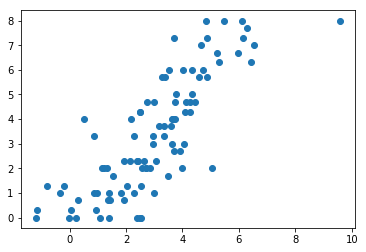

In [47]:
plt.scatter(y_pred,y);

In [48]:
def full_frame(width=None, height=None):
    import matplotlib as mpl
    mpl.rcParams['savefig.pad_inches'] = 0
    figsize = None if width is None else (width, height)
    fig = plt.figure(figsize=figsize)
    ax = plt.axes([0,0,1,1], frameon=False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.autoscale(tight=True)

In [49]:
float(model.coef_), model.intercept_

(0.8705248236656189, 3.4137437)

In [50]:
dmerge.csv["markers"] = 'Unknown survival'
#dmerge.csv["markers"][dmerge.csv.went_icu == "Y"] = "Went ICU (unknown survival)"
dmerge.csv["markers"][dmerge.csv.survival == "N"] = "Deceased"
dmerge.csv["markers"][dmerge.csv.survival == "Y"] = "Survived"

In [51]:
markers = {}
markers_edgecolor = {}
markers["Unknown survival"]= "o"
markers_edgecolor["Unknown survival"]= None
markers["Survived"]= "$O$"
markers_edgecolor["Survived"]= "green"
markers["Deceased"]= "x"
markers_edgecolor["Deceased"]= "red"
# markers["Went ICU (unknown survival)"]= "$I$"
# markers_edgecolor["Went ICU (unknown survival)"]= "red"

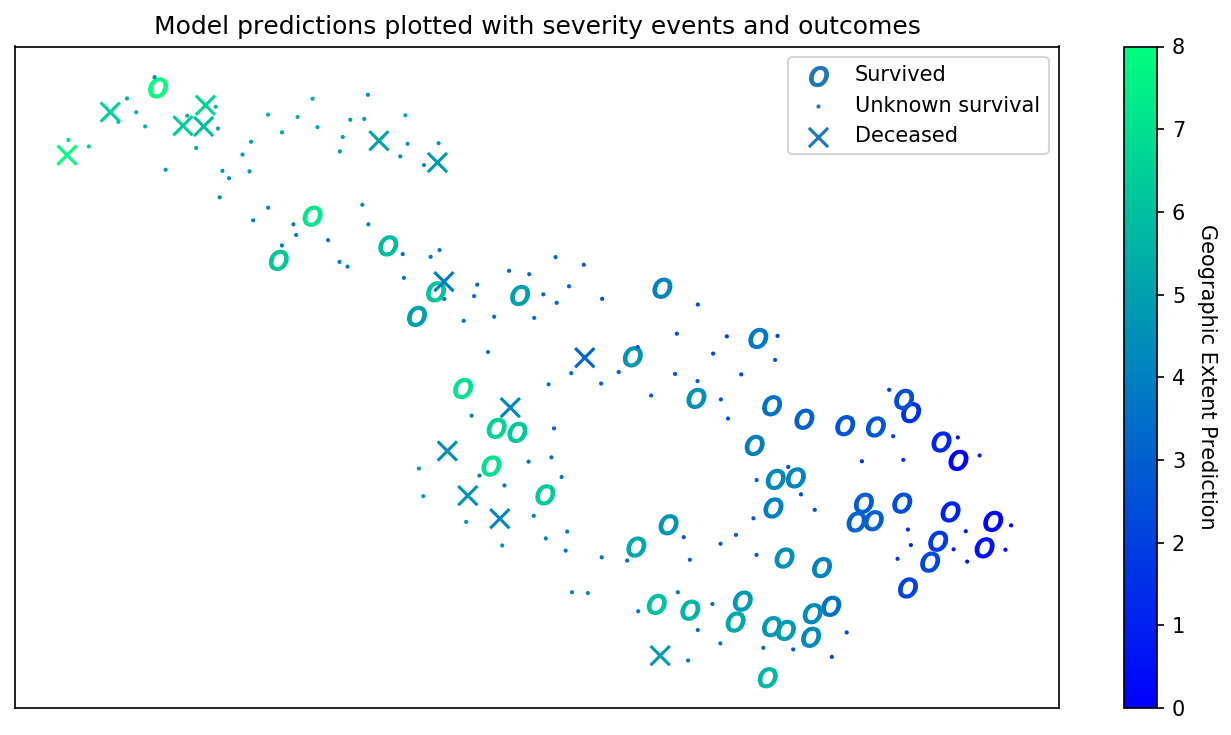

In [52]:
targets = d_pred_geo
fig = plt.figure(0, figsize=(9, 5), dpi=150)

for marker in dmerge.csv["markers"].unique():
    these = dmerge.csv["markers"] == marker
    plt.scatter(X_embedded[:,0][these], 
                X_embedded[:,1][these], 
                #s=(targets==2)*20+1,
                c=targets[these],
                s=1 if markers[marker] == "o" else 85,
                marker=markers[marker],
                cmap="winter",
                label=marker
                );
plt.clim(0,8)
cbar = plt.colorbar();
cbar.set_label('Geographic Extent Prediction', rotation=270, labelpad=15)
plt.title("Model predictions plotted with severity events and outcomes");
plt.legend()
fig.axes[0].get_xaxis().set_visible(False)
fig.axes[0].get_yaxis().set_visible(False)
plt.tight_layout()
plt.savefig('tsne-survival.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()



In [53]:
import torch.nn as nn
import torch.nn.functional as F

class GeoExtentNet(nn.Module):
    def __init__(self):
        super(GeoExtentNet, self).__init__()
        self.model = xrv.models.DenseNet(weights="all")
        self.model.op_threshs = None
        self.theta = torch.from_numpy(np.asarray(model.coef_))
        self.bias = torch.from_numpy(np.asarray(model.intercept_))

    def forward(self, x):
        preds = self.model(x)
        preds = preds[:,xrv.datasets.default_pathologies.index("Lung Opacity")]
        preds = preds*self.theta+self.bias
        return preds

In [54]:
model2 = GeoExtentNet()

In [55]:
list(zip(test_inds,y.iloc[test_inds].round(2), y_pred[test_inds].round(2)))

[(0, 2.3, 2.63),
 (1, 4.0, 2.18),
 (2, 4.7, 2.75),
 (3, 5.7, 3.37),
 (4, 2.0, 3.97),
 (5, 2.7, 3.69),
 (6, 6.0, 4.73),
 (7, 7.3, 6.16),
 (8, 2.0, 5.04),
 (15, 3.7, 3.6),
 (16, 5.7, 4.59),
 (17, 4.3, 4.1),
 (20, 4.7, 4.27),
 (21, 1.3, 2.52),
 (23, 3.3, 3.33),
 (24, 8.0, 4.84),
 (26, 0.3, 0.95),
 (27, 1.7, 1.54),
 (28, 7.0, 4.65),
 (29, 7.7, 6.29),
 (31, 2.0, 1.33),
 (32, 2.0, 2.72),
 (33, 2.0, 1.23),
 (34, 3.0, 3.65),
 (35, 4.7, 4.44),
 (36, 6.3, 5.29),
 (37, 6.0, 3.52),
 (39, 2.3, 1.93),
 (41, 4.0, 0.5),
 (42, 3.3, 0.85),
 (43, 3.7, 3.15),
 (49, 0.0, 1.39),
 (52, 3.0, 2.95),
 (53, 1.0, -0.34),
 (54, 0.0, 1.06),
 (55, 0.3, 0.05),
 (58, 4.3, 2.5),
 (59, 2.0, 2.71),
 (63, 5.0, 3.77),
 (66, 4.7, 4.12),
 (76, 4.3, 2.49),
 (77, 7.3, 3.71),
 (78, 8.0, 5.46),
 (83, 5.7, 3.29),
 (86, 0.3, -1.16),
 (87, 1.0, 0.86),
 (90, 4.0, 3.65),
 (91, 4.7, 3.74),
 (92, 0.7, 1.93)]

In [56]:
#dmerge[idxs[10]]

In [57]:
#dmerge.csv.iloc[idxs[15]]

In [67]:
idx = 29
img = torch.from_numpy(dmerge[idxs[idx]]["img"]).unsqueeze(0).requires_grad_()
a = model2(img)
print("pred",a)
print("gt", y.iloc[idx])
grads = torch.autograd.grad(a, img)[0][0][0]
#grads = torch.abs(torch.autograd.grad(a, img)[0][0][0])

pred tensor([6.2909], grad_fn=<AddBackward0>)
gt 7.7


In [68]:
dmerge.csv.iloc[idxs[idx]].filename

'31BA3780-2323-493F-8AED-62081B9C383B.jpeg'

In [69]:
import skimage, skimage.filters
blurred = skimage.filters.gaussian(grads**2, sigma=(5, 5), truncate=3.5)

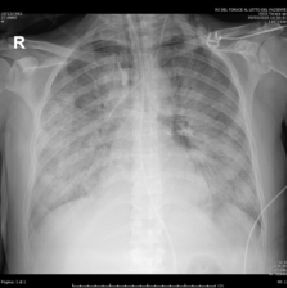

In [70]:
full_frame()
plt.imshow(img[0][0].detach(), cmap="gray");

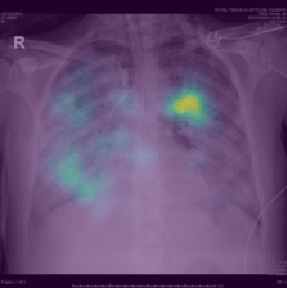

In [71]:
full_frame()
plt.imshow(img[0][0].detach(), cmap="gray")
plt.imshow(blurred, alpha=0.5);

In [72]:
# plt.imshow(img[0][0].detach(), cmap="gray")
# plt.imshow(torch.abs(grads), alpha=0.5)
# plt.axis('off')

In [73]:
# plt.imshow(img[0][0].detach(), cmap="gray")
# plt.imshow(torch.abs(grads), alpha=0.5)
# print(plt.gca().get_images()[1].get_clim())
# plt.gca().get_images()[1].set_clim(0, 0.0003)
# plt.axis('off')

In [74]:
img.detach().max()

tensor(1004.7975)

In [75]:
torch.abs(grads).max()

tensor(0.0007)